# Mini Project 
Developing a content based approach on a book recommendation system and exploring the results

The dataset I am using was found off kaggle:  https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset

The code used in this notebook is from the Week 2.1 Notebook on Content-based filtering and Week 6.1 Notebook on Embeddings

## Part One - Making a recommendation system

Using the notebook from Week 2.1, I'm going to make a recommendation system based off of book data.

#### Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import spatial

In [152]:
books = pd.read_csv('Books Data with Category Language and Summary/Preprocessed_data.csv')
books.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


In [153]:
books.columns #so from this I can see the data that can be used as features for the recommender system

Index(['Unnamed: 0', 'user_id', 'location', 'age', 'isbn', 'rating',
       'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city',
       'state', 'country'],
      dtype='object')

In [154]:
books.shape #my laptop is unable to process this amount of data so my plan is to reduce the number of rows

(1031175, 19)

In [155]:
#first I want to see what the most popular categories are - as can be seen the most common is '9' which as it is not clearly broken down specifically
#I will remove all the values containing '9' as the category
books['Category'].value_counts() 

Category
9                                            406102
['Fiction']                                  385135
['Juvenile Fiction']                          39617
['Biography & Autobiography']                 22390
['Humor']                                      8500
                                              ...  
['Angel (Fictitious character : Whedon)']         1
['Face']                                          1
['Church renewal']                                1
['Supermarkets']                                  1
['Alternative histories']                         1
Name: count, Length: 6448, dtype: int64

In [156]:
books['Category1'] = books['Category'].astype(str)
books['Category1'] = books['Category'].str.strip('[]').str.replace(' ','').str.replace("'",'')
books['Category1'] = books['Category'].str.split(',')

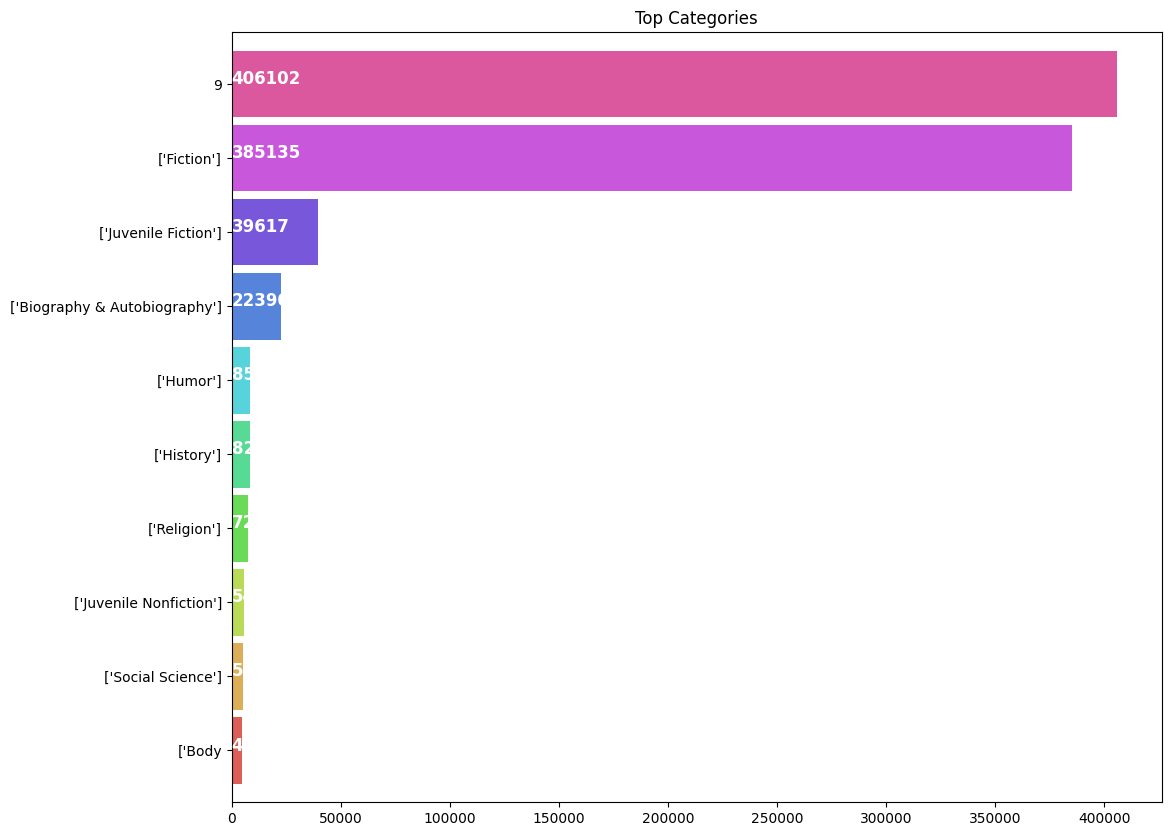

In [157]:
plt.subplots(figsize=(12,10))
list1 = []
for i in books['Category1']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Categories')
plt.show()

In [158]:
books = books[~books['Category'].str.contains('9')] # removing 9 from the category column

In [159]:
books['Category'] = books['Category'].astype(str)
books['Category'] = books['Category'].str.strip('[]').str.replace(' ','').str.replace("'",'')
books['Category'] = books['Category'].str.split(',')

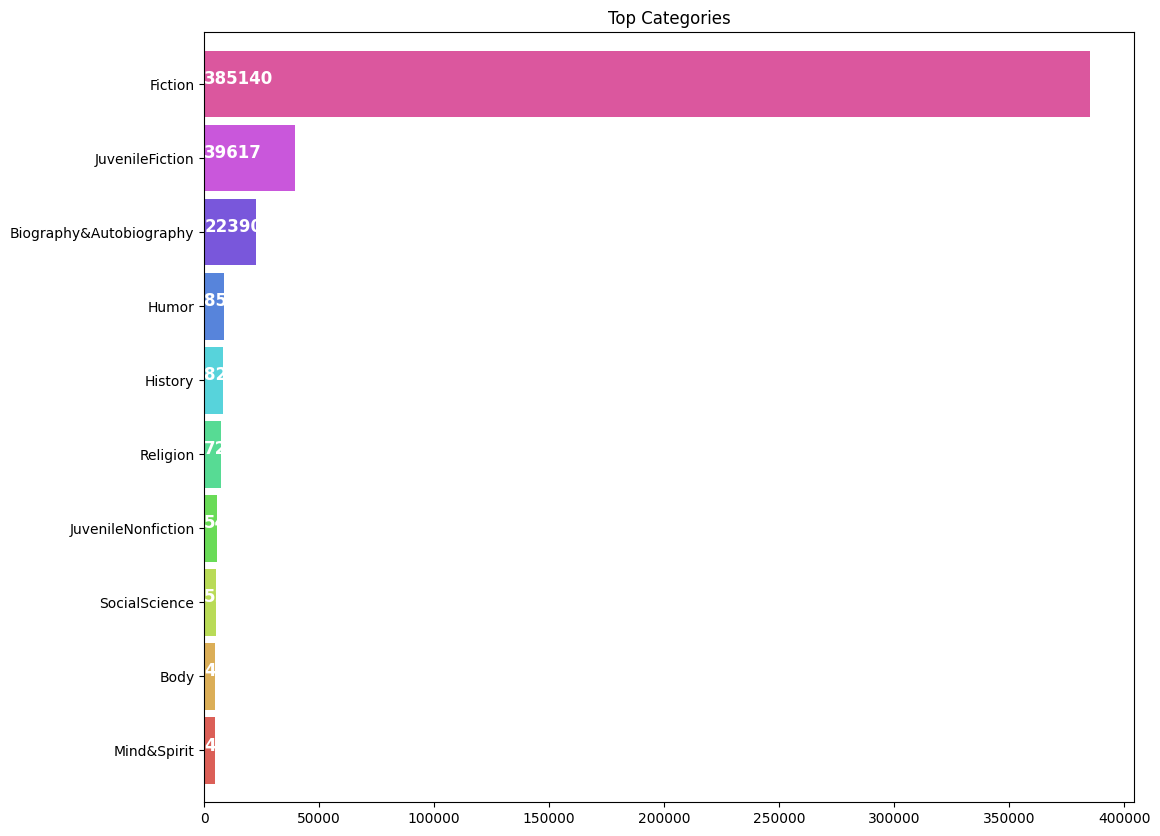

In [160]:
plt.subplots(figsize=(12,10))
list1 = []
for i in books['Category']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Categories')
plt.show()

In [161]:
books = books.sample(n=5000, random_state=1) #reduced number of rows to increase speed of processing, but keep the distribution of the categories
books.shape

(5000, 20)

In [162]:
#making a vocab for the categories
genreList = []
for index, row in books.iterrows():
    genres = row["Category"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #we can see for definite that '9' has been removed

['Fiction',
 'Cooking',
 'TrueCrime',
 'Models(Persons)',
 'JuvenileFiction',
 'Authors',
 'Comics&GraphicNovels',
 'Biography&Autobiography',
 'LiteraryCollections',
 'Humor']

In [163]:
#one hot encoding 
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [164]:
books['category_bin'] = books['Category'].apply(lambda x: binary(x)) #this is the function that struggles the most with the large number of rows
books['category_bin'].head()

21473     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
443515    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
704843    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
542077    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
385634    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: category_bin, dtype: object

In [165]:
def Similarity(book_Id1, book_Id2):
    a = books.iloc[book_Id1]
    b = books.iloc[book_Id2]
    
    categoryA = a['category_bin']
    categoryB = b['category_bin']
    
    categoriyDistance = spatial.distance.cosine(categoryA, categoryB)
    return categoriyDistance #working out the cosine similarity between books in the dataset

In [166]:
books

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,...,img_m,img_l,Summary,Language,Category,city,state,country,Category1,category_bin
21473,21473,114444,"alexandria, virginia, usa",34.0000,0446353205,0,The Charm School,Nelson DeMille,1989.0,Warner Books,...,http://images.amazon.com/images/P/0446353205.0...,http://images.amazon.com/images/P/0446353205.0...,"The secret concerns &quot;The Charm School,&qu...",en,[Fiction],alexandria,virginia,usa,[['Fiction']],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
443515,443515,69493,"fpo, armed forces pacific (ap), japan",42.0000,0452276381,0,The African-American Kitchen: Cooking from Our...,Angela Shelf Medearis,1997.0,Plume Books,...,http://images.amazon.com/images/P/0452276381.0...,http://images.amazon.com/images/P/0452276381.0...,A collection of recipes from the diverse tradi...,en,[Cooking],fpo,armed forces pacific (ap),japan,[['Cooking']],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
704843,704843,41455,"toronto, ontario, canada",34.7439,006103083X,5,A Week in the Zone,Barry Sears,2000.0,ReganBooks,...,http://images.amazon.com/images/P/006103083X.0...,http://images.amazon.com/images/P/006103083X.0...,"With A Week in the Zone, everyone can start on...",en,[Cooking],toronto,ontario,canada,[['Cooking']],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
542077,542077,61901,"tucson, arizona, usa",63.0000,0743202988,8,Heart Full of Lies: A True Story of Desire and...,Ann Rule,2003.0,Free Press,...,http://images.amazon.com/images/P/0743202988.0...,http://images.amazon.com/images/P/0743202988.0...,&quot;Liysa and Chris Northon seemed the epito...,en,[TrueCrime],tucson,arizona,usa,[['True Crime']],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
385634,385634,171970,"elmhurst, illinois, usa",34.7439,0140264795,6,Rosie: A Novel,Anne Lamott,1997.0,Penguin Books,...,http://images.amazon.com/images/P/0140264795.0...,http://images.amazon.com/images/P/0140264795.0...,"Precocious, eight-year-old Rosie Ferguson disc...",en,[Fiction],elmhurst,illinois,usa,[['Fiction']],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226918,226918,146421,"spotswood, victoria, australia",44.0000,006098726X,9,Stupid White Men : ...And Other Sorry Excuses ...,Michael Moore,2004.0,Regan Books,...,http://images.amazon.com/images/P/006098726X.0...,http://images.amazon.com/images/P/006098726X.0...,Tired and skeptical of George W. Bush&#39;s hi...,en,[PoliticalScience],spotswood,victoria,australia,[['Political Science']],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
966959,966959,274061,"gahanna/columbus, ohio, usa",26.0000,0373118074,0,Ruthless Contract (Wedlocked!) (Harlequin Pres...,Alex Ross,1996.0,Harlequin,...,http://images.amazon.com/images/P/0373118074.0...,http://images.amazon.com/images/P/0373118074.0...,Ruthless Contract by Kathryn Ross released on ...,en,[Fiction],gahanna/columbus,ohio,usa,[['Fiction']],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
653107,653107,183340,"n/a, n/a, usa",34.7439,0553571729,0,The Red Scream,Mary Willis Walker,1995.0,Crimeline,...,http://images.amazon.com/images/P/0553571729.0...,http://images.amazon.com/images/P/0553571729.0...,"Texas reporter Molly Cates, whose book describ...",en,[Fiction],NaN,NaN,usa,[['Fiction']],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
271746,271746,20313,"prince george, british columbia, canada",34.7439,0064400018,0,Little House in the Big Woods,Laura Ingalls Wilder,1953.0,HarperTrophy,...,http://images.amazon.com/images/P/0064400018.0...,http://images.amazon.com/images/P/0064400018.0...,New York Times bestselling author RACHEL GIBSO...,en,[JuvenileFiction],prince george,british columbia,canada,[['Juvenile Fiction']],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [167]:
Similarity(1,100) #checking similarity between any 2 random books

1.0

In [168]:
print(books.iloc[1])
print(books.iloc[100])

Unnamed: 0                                                        443515
user_id                                                            69493
location                           fpo, armed forces pacific (ap), japan
age                                                                 42.0
isbn                                                          0452276381
rating                                                                 0
book_title             The African-American Kitchen: Cooking from Our...
book_author                                        Angela Shelf Medearis
year_of_publication                                               1997.0
publisher                                                    Plume Books
img_s                  http://images.amazon.com/images/P/0452276381.0...
img_m                  http://images.amazon.com/images/P/0452276381.0...
img_l                  http://images.amazon.com/images/P/0452276381.0...
Summary                A collection of recipes from

In [169]:
new_id = list(range(0,books.shape[0]))
books['new_id']=new_id
books=books[['book_title','Category','rating','category_bin','new_id']]
books.head()

,book_title,Category,rating,category_bin,new_id
21473,The Charm School,[Fiction],0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
443515,The African-American Kitchen: Cooking from Our...,[Cooking],0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
704843,A Week in the Zone,[Cooking],5,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
542077,Heart Full of Lies: A True Story of Desire and...,[TrueCrime],8,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
385634,Rosie: A Novel,[Fiction],6,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4


In [170]:
new_id = list(range(0,books.shape[0]))
books['new_id']=new_id
books=books[['book_title','Category','rating','category_bin','new_id']]
books.head()

import operator

def predict_score(name):
    #name = input('Enter a movie title: ')
    new_book = books[books['book_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Book: ',new_book.book_title.values[0])
    def getNeighbors(baseBook, K):
        distances = []
    
        for index, book in books.iterrows():
            if book['new_id'] != baseBook['new_id'].values[0]:
                dist = Similarity(baseBook['new_id'].values[0], book['new_id'])
                distances.append((book['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_book, K)
    
    print('\nRecommended Books: \n')
    for neighbor in neighbors:
        avgRating = avgRating+books.iloc[neighbor[0]][2]  
        print( books.iloc[neighbor[0]][0]+" | Categories: "+str(books.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(books.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K
   

In [171]:
predict_score('The Icarus Agenda') #the ratings here are all over the place

Selected Book:  The Icarus Agenda

Recommended Books: 

The Charm School | Categories: 'Fiction' | Rating: 0
Rosie: A Novel | Categories: 'Fiction' | Rating: 6
The Perfect Elizabeth : A Tale of Two Sisters | Categories: 'Fiction' | Rating: 7
War of the Crowns : A Novel of Ancient Egypt (Magnificent Queen  of Freedom Trilogy) | Categories: 'Fiction' | Rating: 0
Tropic of Cancer | Categories: 'Fiction' | Rating: 0
Darkness Peering | Categories: 'Fiction' | Rating: 0
By Love's Command | Categories: 'Fiction' | Rating: 0
Waterdeep (Forgotten Realms:  Avatar Trilogy, Book 3) | Categories: 'Fiction' | Rating: 0
The Red Room | Categories: 'Fiction' | Rating: 8
SABER AND SHADOW | Categories: 'Fiction' | Rating: 0




# Changing the system 

So I have created the recommeder system though it should be obvious from the results that it is not very good at what it does. Whilst I do want to look at specific genres I am going to focus on getting the recommender to prioritise books with higher ratings as well as the category. 

TO do this I am first going to sort the books so that I have the mean rating for all books as well as how many times they've been rated so that I can have better judgement on the importance of each rating

In [172]:
books.groupby('book_title')['rating'].mean().sort_values(ascending=False).head() #compairing the mean ratings with the number of ratings

book_title
The Butlerian Jihad (Dune Series)                                     10.0
Is Wanting Enough?: A Novel                                           10.0
The Autobiography of Saint Therese of Lisieux: The Story of a Soul    10.0
Inside Vineyland                                                      10.0
Naranja Mecanica, La                                                  10.0
Name: rating, dtype: float64

In [362]:
#want the dataset as I was oritionally 
books = pd.read_csv('Books Data with Category Language and Summary/Preprocessed_data.csv')
books.head(3)

books = books[~books['Category'].str.contains('9')]

books['Category'] = books['Category'].astype(str)
books['Category'] = books['Category'].str.strip('[]').str.replace(' ','').str.replace("'",'')
books['Category'] = books['Category'].str.split(',')

books = books.sample(n=5000, random_state=1)  #doing some of the pre-processing again
books.shape

(5000, 19)

In [259]:
books.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
21473,21473,114444,"alexandria, virginia, usa",34.0000,0446353205,0,The Charm School,Nelson DeMille,1989.0,Warner Books,http://images.amazon.com/images/P/0446353205.0...,http://images.amazon.com/images/P/0446353205.0...,http://images.amazon.com/images/P/0446353205.0...,"The secret concerns &quot;The Charm School,&qu...",en,[Fiction],alexandria,virginia,usa
443515,443515,69493,"fpo, armed forces pacific (ap), japan",42.0000,0452276381,0,The African-American Kitchen: Cooking from Our...,Angela Shelf Medearis,1997.0,Plume Books,http://images.amazon.com/images/P/0452276381.0...,http://images.amazon.com/images/P/0452276381.0...,http://images.amazon.com/images/P/0452276381.0...,A collection of recipes from the diverse tradi...,en,[Cooking],fpo,armed forces pacific (ap),japan
704843,704843,41455,"toronto, ontario, canada",34.7439,006103083X,5,A Week in the Zone,Barry Sears,2000.0,ReganBooks,http://images.amazon.com/images/P/006103083X.0...,http://images.amazon.com/images/P/006103083X.0...,http://images.amazon.com/images/P/006103083X.0...,"With A Week in the Zone, everyone can start on...",en,[Cooking],toronto,ontario,canada


In [363]:
books.shape

(5000, 19)

In [364]:
isbn = books['isbn'].unique()
print(isbn[:5])
print("This is the shape of the isbn numbers: \n", isbn.shape) #most of the books we have in this dataset are unique
#this makes it difficult to put too much weight behind the ratings but we can still use it as a feature

['0446353205' '0452276381' '006103083X' '0743202988' '0140264795']
This is the shape of the isbn numbers: 
 (4397,)


isbn,0001981625,0002005018,0002258579,0002550555,0004707532,0006175473,0006376010,0007110928,000716226X,0020199201,...,8483026007,8483072718,8483105845,8483109034,8484504328,8495501007,8495501104,880781000X,8838910987,8983140356
user_id,,,,,,,,,,,,,,,,,,,,,
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


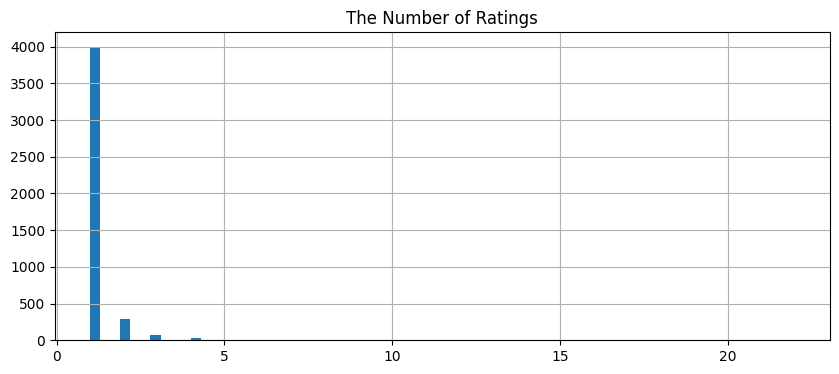

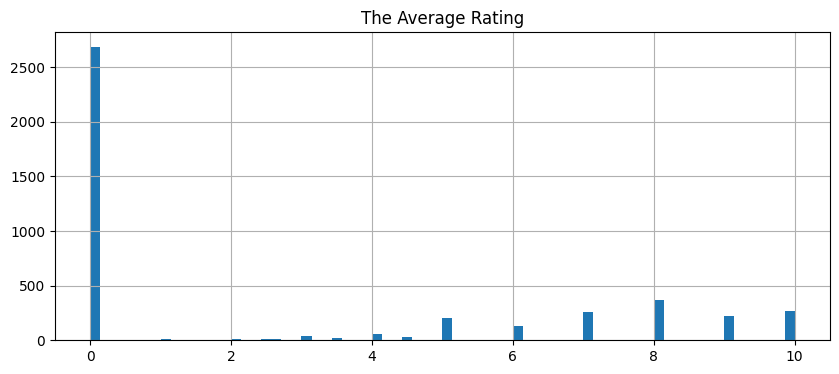

In [365]:
books.groupby('isbn')['rating'].mean().sort_values(ascending=False) #ranking the isbn numbers by their average rating
books.groupby('isbn')['rating'].count().sort_values(ascending=False) #ranking the isbn numbers by the number of times they have been rated

ratings = pd.DataFrame(books.groupby('isbn')['rating'].mean()) #putting them into a df
ratings['num of ratings'] = pd.DataFrame(books.groupby('isbn')['rating'].count())
ratings.head()

#plotting the number of ratings
plt.figure(figsize=(10,4))
plt.title("The Number of Ratings")
ratings['num of ratings'].hist(bins=70)

#plotting the average ratings
plt.figure(figsize=(10,4))
plt.title("The Average Rating")
ratings['rating'].hist(bins=70)

#creating a matrix of the books and their ratings
bookmat = books.pivot_table(index='user_id',columns='isbn',values='rating')
bookmat.head()

Its quite interesting to me that most of the ratings are 0, not surprising considering most users are probably less invested in reviewing the books they get but I wonder if instead of reducing the dataset down by making it smaller but keeping the distribution I could reduce it by removing and book that has a rating of 0. Whilst this might skew my data because I'm removing some data I think if I standard the data after the fact it should reduce this skew. Ultimately it takes effort to review a book and thus for it be low or high but not 0 reflects some thought by the user

In [508]:
books = pd.read_csv('Books Data with Category Language and Summary/Preprocessed_data.csv')
books.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


In [509]:
books = books[books['rating'] != 0]
books.shape

(383852, 19)

In [510]:
#check if there are any 0 ratings
books[books['rating'] == 0]

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country


In [511]:
#convert rating into string values in a new column
books['rating1'] = books['rating'].astype(str)

<Axes: title={'center': 'The Average Rating'}>

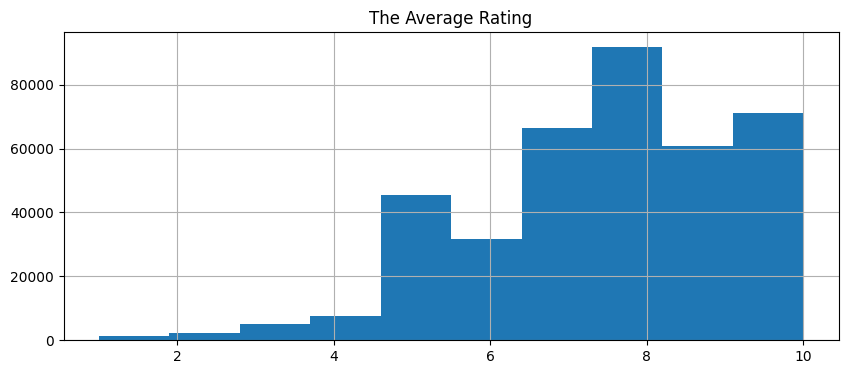

In [512]:
plt.figure(figsize=(10,4))
plt.title("The Average Rating")
books['rating'].hist(bins=10)


So know the dataframe doesn't contain the rating 0, from here we can further reduce the dataset whilst keeping this distribution the same so that I can process the data.

In [513]:
books = books.sample(n=10000, random_state=1) #reducing hte dataset again
books.shape

(10000, 20)

In [514]:
books

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country,rating1
55849,55849,272202,"cleveland, mississippi, usa",34.7439,0060392452,9,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002.0,Regan Books,http://images.amazon.com/images/P/0060392452.0...,http://images.amazon.com/images/P/0060392452.0...,http://images.amazon.com/images/P/0060392452.0...,So if you&#39;re feeling the same way and you&...,en,['Political Science'],cleveland,mississippi,usa,9
262176,262176,74655,"wien, wien, austria",32.0000,3453212045,5,Sushi fÃ?Â¼r AnfÃ?Â¤nger.,Marian Keyes,2002.0,Heyne,http://images.amazon.com/images/P/3453212045.0...,http://images.amazon.com/images/P/3453212045.0...,http://images.amazon.com/images/P/3453212045.0...,9,9,9,wien,wien,austria,5
292564,292564,124946,"elizabeth, arkansas, usa",56.0000,0767915054,4,A Girl Named Zippy: Growing Up Small in Moorel...,HAVEN KIMMEL,2002.0,Broadway Books,http://images.amazon.com/images/P/0767915054.0...,http://images.amazon.com/images/P/0767915054.0...,http://images.amazon.com/images/P/0767915054.0...,The author offers a chronicle of growing up in...,en,['Biography & Autobiography'],elizabeth,arkansas,usa,4
190720,190720,102275,"saint clair, michigan, usa",52.0000,0142000345,10,A Common Life: The Wedding Story (Beloved Mitf...,Jan Karon,2002.0,Viking Books,http://images.amazon.com/images/P/0142000345.0...,http://images.amazon.com/images/P/0142000345.0...,http://images.amazon.com/images/P/0142000345.0...,The creator of the Mitford stories goes back t...,en,['Fiction'],saint clair,michigan,usa,10
10301,10301,130950,"jersey city, new jersey, usa",32.0000,0671027360,9,Angels & Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,9,9,9,jersey city,new jersey,usa,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530362,530362,72147,"merrimack, new hampshire,",34.7439,0425141977,8,A Share in Death,Deborah Crombie,1994.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425141977.0...,http://images.amazon.com/images/P/0425141977.0...,http://images.amazon.com/images/P/0425141977.0...,9,9,9,merrimack,"new hampshire,",NaN,8
920652,920652,185233,"winnemucca, nevada, usa",31.0000,0553143573,5,Who Killed Harlowe Thrombey,Edward Packard,1981.0,Bantam Books (Mm),http://images.amazon.com/images/P/0553143573.0...,http://images.amazon.com/images/P/0553143573.0...,http://images.amazon.com/images/P/0553143573.0...,9,9,9,winnemucca,nevada,usa,5
938233,938233,160401,"akron, ohio, usa",30.0000,0373030886,5,"Perfect Marriage (Harlequin Romance, No 3088)",Lee Stafford,1990.0,Harlequin,http://images.amazon.com/images/P/0373030886.0...,http://images.amazon.com/images/P/0373030886.0...,http://images.amazon.com/images/P/0373030886.0...,9,9,9,akron,ohio,usa,5
748394,748394,64726,"eaubonne, ile de france, france",27.0000,2070320006,7,Oeuvres complÃ?Â¨tes,LautrÃ?Â©amont,1973.0,Gallimard,http://images.amazon.com/images/P/2070320006.0...,http://images.amazon.com/images/P/2070320006.0...,http://images.amazon.com/images/P/2070320006.0...,Les Chants de Maldoror sont une épopée en pros...,fr,['Poetry'],eaubonne,ile de france,france,7


In [515]:
#make a vocab of the isbn numbers
isbnList = []
for index, row in books.iterrows():
    isbn = row["isbn"]
    
    if isbn not in isbnList:
        isbnList.append(isbn)
isbnList[:10]


['0060392452',
 '3453212045',
 '0767915054',
 '0142000345',
 '0671027360',
 '0310201985',
 '0380789019',
 '0801630886',
 '0375725784',
 '1555136656']

In [516]:
#rate the isnb numbers by their average rating and the number of times they have been rated
books.groupby('isbn')['rating'].mean().sort_values(ascending=False)
books.groupby('isbn')['rating'].count().sort_values(ascending=False)

#creating a dataframe with the average rating and the number of times a book has been rated
ratings = pd.DataFrame(books.groupby('isbn')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(books.groupby('isbn')['rating'].count())
ratings.head

<bound method NDFrame.head of             rating  num of ratings
isbn                              
0001714600     8.0               1
0002184974     7.0               1
0002219980     6.0               1
0002243962     4.0               1
0002250101     7.0               1
...            ...             ...
982020125X     6.0               1
9879065271     9.0               1
9879338286     5.0               1
9997405137     7.0               1
9998914140    10.0               1

[8486 rows x 2 columns]>

In [517]:
#filter the ratings that were rated 2 times
ratings2 = ratings[ratings['num of ratings'] > 2]
ratings2.shape

(291, 2)

In [518]:
#for each user create a matrix that contains the isbn and the rating they gave it
bookmat = books.pivot_table(index='user_id',columns='isbn',values='rating')
bookmat.head() #this is a very sparse matrix

isbn,0001714600,0002184974,0002219980,0002243962,0002250101,0002257580,0006161529,0006176909,0006179223,0006281729,...,9724115380,9724606287,9728423462,9799023386,9813056363,982020125X,9879065271,9879338286,9997405137,9998914140
user_id,,,,,,,,,,,,,,,,,,,,,
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [519]:
#making a vocab for the categories
genreList = []
for index, row in books.iterrows():
    genres = row["isbn"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #we can see for definite that '9' has been removed

['0', '6', '3', '9', '2', '4', '5', '1', '7', '8']

In [520]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [521]:
books['isbn_bin'] = books['isbn'].apply(lambda x: binary(x))
books['isbn_bin'].head()

55849     [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
262176    [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
292564    [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]
190720    [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
10301     [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Name: isbn_bin, dtype: object

In [522]:
books[:3]

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,...,img_m,img_l,Summary,Language,Category,city,state,country,rating1,isbn_bin
55849,55849,272202,"cleveland, mississippi, usa",34.7439,0060392452,9,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002.0,Regan Books,...,http://images.amazon.com/images/P/0060392452.0...,http://images.amazon.com/images/P/0060392452.0...,So if you&#39;re feeling the same way and you&...,en,['Political Science'],cleveland,mississippi,usa,9,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]"
262176,262176,74655,"wien, wien, austria",32.0000,3453212045,5,Sushi fÃ?Â¼r AnfÃ?Â¤nger.,Marian Keyes,2002.0,Heyne,...,http://images.amazon.com/images/P/3453212045.0...,http://images.amazon.com/images/P/3453212045.0...,9,9,9,wien,wien,austria,5,"[1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]"
292564,292564,124946,"elizabeth, arkansas, usa",56.0000,0767915054,4,A Girl Named Zippy: Growing Up Small in Moorel...,HAVEN KIMMEL,2002.0,Broadway Books,...,http://images.amazon.com/images/P/0767915054.0...,http://images.amazon.com/images/P/0767915054.0...,The author offers a chronicle of growing up in...,en,['Biography & Autobiography'],elizabeth,arkansas,usa,4,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]"


In [523]:
from scipy import spatial

def Similarity(book_Id1, book_Id2):
    a = books.iloc[book_Id1]
    b = books.iloc[book_Id2]
    
    categoryA = a['isbn_bin']
    categoryB = b['isbn_bin']
    
    categoriyDistance = spatial.distance.cosine(categoryA, categoryB)
    return categoriyDistance

In [524]:
Similarity(1,100)

0.38278660015163246

In [506]:
print(books.iloc[1])
books.iloc[100]

book_title                                      The Icarus Agenda
location                              [lascruces, newmexico, usa]
rating                                                          0
location_bin    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
new_id                                                          1
Name: 320829, dtype: object


book_title       The Thirteen Problems (The Tuesday Club Murders)
location                            [brownsmills, newjersey, usa]
rating                                                          0
location_bin    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
new_id                                                        100
Name: 576095, dtype: object

In [538]:
new_id = list(range(0,books.shape[0]))
books['new_id']=new_id
books=books[['book_title','isbn','rating','isbn_bin','new_id']]
books.head()

import operator

def predict_score(name):
    #name = input('Enter a movie title: ')
    new_book = books[books['book_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Book: ',new_book.book_title.values[0])
    def getNeighbors(baseBook, K):
        distances = []
    
        for index, book in books.iterrows():
            if book['new_id'] != baseBook['new_id'].values[0]:
                dist = Similarity(baseBook['new_id'].values[0], book['new_id'])
                distances.append((book['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_book, K)
    
    print('\nRecommended Books: \n')
    for neighbor in neighbors:
        avgRating = avgRating+books.iloc[neighbor[0]][2]  
        print( books.iloc[neighbor[0]][0]+" | ISBN: "+str(books.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(books.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K
   

In [539]:
predict_score('The Bourne Identity')

Selected Book:  The Bourne Identity

Recommended Books: 

The Jester | ISBN: 0316602051 | Rating: 5
The Crow Road | ISBN: 0356206521 | Rating: 10
On This Day | ISBN: 0060512113 | Rating: 6
Four Quartets (Harvest Book) | ISBN: 0156332256 | Rating: 8
Anne of Ingleside (Anne of Green Gables Novels (Paperback)) | ISBN: 0553213156 | Rating: 8
Behind the Scenes at the Museum : A Novel | ISBN: 0312150601 | Rating: 9
Daughters of Memory | ISBN: 1565120310 | Rating: 7
Oscar et la dame rose | ISBN: 2226135022 | Rating: 4
The Hours: A Novel | ISBN: 0312305060 | Rating: 8
A Little Princess | ISBN: 0553212036 | Rating: 9




Because ISBN numbers contain information about the publisher and book it does provide value in seeing the similarities between them, though it doesn't have any impact on whether they are rated highly, as can be see nhere, the two books sampled have the ratings 5 and 4 respectively.

In [441]:
genreList = []
for index, row in books.iterrows():
    genres = row["rating1"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #we can see for definite that '9' has been removed

['9', '5', '4', '1', '0', '6', '8', '7', '3', '2']

In [442]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [443]:
books['rating_bin'] = books['rating1'].apply(lambda x: binary(x))
books['rating_bin'].head()

55849     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
262176    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
292564    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
190720    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
10301     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: rating_bin, dtype: object

In [444]:
from scipy import spatial

def Similarity(book_Id1, book_Id2):
    a = books.iloc[book_Id1]
    b = books.iloc[book_Id2]
    
    categoryA = a['rating_bin']
    categoryB = b['rating_bin']
    
    categoriyDistance = spatial.distance.cosine(categoryA, categoryB)
    return categoriyDistance

In [445]:
Similarity(1,100)

1.0

In [446]:
print(books.iloc[1])
books.iloc[100]

Unnamed: 0                                                        262176
user_id                                                            74655
location                                             wien, wien, austria
age                                                                 32.0
isbn                                                          3453212045
rating                                                                 5
book_title                                     Sushi fÃ?Â¼r AnfÃ?Â¤nger.
book_author                                                 Marian Keyes
year_of_publication                                               2002.0
publisher                                                          Heyne
img_s                  http://images.amazon.com/images/P/3453212045.0...
img_m                  http://images.amazon.com/images/P/3453212045.0...
img_l                  http://images.amazon.com/images/P/3453212045.0...
Summary                                            

Unnamed: 0                                                        731020
user_id                                                           177046
location                                         berlin, berlin, germany
age                                                                 23.0
isbn                                                          3453149785
rating                                                                 4
book_title                               Der Magier. Das Tor ins Nichts.
book_author                                            Wolfgang Hohlbein
year_of_publication                                               1999.0
publisher                                                          Heyne
img_s                  http://images.amazon.com/images/P/3453149785.0...
img_m                  http://images.amazon.com/images/P/3453149785.0...
img_l                  http://images.amazon.com/images/P/3453149785.0...
Summary                                            

In [575]:
#remove the category '9' from the dataset
books2 = books[~books['Category'].str.contains('9')]
#remove the rating '0' from the ratings
books2 = books2[books2['rating'] != 0]

books2.shape

(231451, 19)

In [576]:
#reduce the dataset keeping the ratings distribution the same
books2 = books2.sample(n=10000, random_state=1)
books2.shape

(10000, 19)

<Axes: title={'center': 'The Average Rating'}>

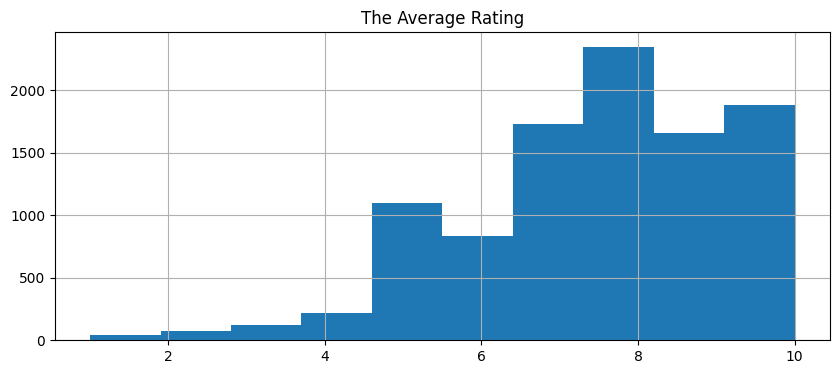

In [577]:
plt.figure(figsize=(10,4))
plt.title("The Average Rating")
books2['rating'].hist(bins=10) #the distribution has changed but not significantly

In [ ]:
new_id = list(range(0,books.shape[0]))
books['new_id']=new_id
books=books[['book_title','isbn','rating','isbn_bin','new_id']]
books.head()

import operator

def predict_score(name):
    #name = input('Enter a movie title: ')
    new_book = books[books['book_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Book: ',new_book.book_title.values[0])
    def getNeighbors(baseBook, K):
        distances = []
    
        for index, book in books.iterrows():
            if book['new_id'] != baseBook['new_id'].values[0]:
                dist = Similarity(baseBook['new_id'].values[0], book['new_id'])
                distances.append((book['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_book, K)
    
    print('\nRecommended Books: \n')
    for neighbor in neighbors:
        avgRating = avgRating+books.iloc[neighbor[0]][2]  
        print( books.iloc[neighbor[0]][0]+" | ISBN: "+str(books.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(books.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K

KeyError: "['isbn_bin'] not in index"

In [544]:
#make a prediction for a different book
predict_score('The Bourne Identity')

Selected Book:  The Bourne Identity

Recommended Books: 

The Jester | ISBN: 0316602051 | Rating: 5
The Crow Road | ISBN: 0356206521 | Rating: 10
On This Day | ISBN: 0060512113 | Rating: 6
Four Quartets (Harvest Book) | ISBN: 0156332256 | Rating: 8
Anne of Ingleside (Anne of Green Gables Novels (Paperback)) | ISBN: 0553213156 | Rating: 8
Behind the Scenes at the Museum : A Novel | ISBN: 0312150601 | Rating: 9
Daughters of Memory | ISBN: 1565120310 | Rating: 7
Oscar et la dame rose | ISBN: 2226135022 | Rating: 4
The Hours: A Novel | ISBN: 0312305060 | Rating: 8
A Little Princess | ISBN: 0553212036 | Rating: 9




## Recommend books based on the users location

In [545]:
#create a recommender system that recommends books based on the location of the user
#loading in the dataset
books = pd.read_csv('Books Data with Category Language and Summary/Preprocessed_data.csv')
books.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


In [547]:
location = books['location'].unique()
location.shape #there are many unique locations, I want to see if I can get just the country from the location

(22480,)

In [555]:
#they already have the city, state and country separated so I will make a vocab straight from the country column
countryList = []
for index, row in books.iterrows():
    country = row["country"]
    
    if country not in countryList:
        countryList.append(country)
countryList


[' usa',
 ' canada',
 ' n/a',
 '',
 ' malaysia',
 ' spain',
 ' new zealand',
 ' finland',
 ' united kingdom',
 ' portugal',
 ' brazil',
 ' germany',
 ' austria',
 ' italy',
 ' netherlands',
 ' australia',
 ' france',
 ' costa rica',
 ' poland',
 ' us',
 ' idaho',
 ' iran',
 ' aruba',
 ' india',
 ' pakistan',
 ' taiwan',
 ' singapore',
 ' argentina',
 ' romania',
 ' greece',
 ' england',
 ' ireland',
 ' belgium',
 ' philippines"',
 ' mexico',
 ' philippines',
 ' south africa',
 ' burkina faso',
 ' kansas',
 ' ile de france',
 ' croatia',
 ' switzerland',
 ' denmark',
 ' rwanda',
 ' yugoslavia',
 ' turkey',
 ' china',
 ' japan',
 ' illinois',
 ' qatar',
 ' latvia',
 ' sweden',
 ' kuwait',
 ' indonesia',
 ' nepal',
 ' peru',
 ' venezuela',
 ' south korea"',
 ' hong kong',
 '61 men',
 ' cambridgeshire',
 ' united states',
 ' north carolina',
 ' slovakia',
 ' norway',
 ' dominican republic',
 ' ontario',
 ' bosnia and herzegovina',
 ' south korea',
 ' macedonia',
 ' kenya',
 ' mauritius',
 

In [554]:
#remove nan values from the country list
countryList = [x for x in countryList if str(x) != 'nan']
#remove n/a values from the country list
countryList = [x for x in countryList if str(x) != 'n/a']
#remove empty values from the country list
countryList = [x for x in countryList if str(x) != '']
len(countryList)

406

In [559]:
#make the country column into a string
books['country'] = books['country'].astype(str)

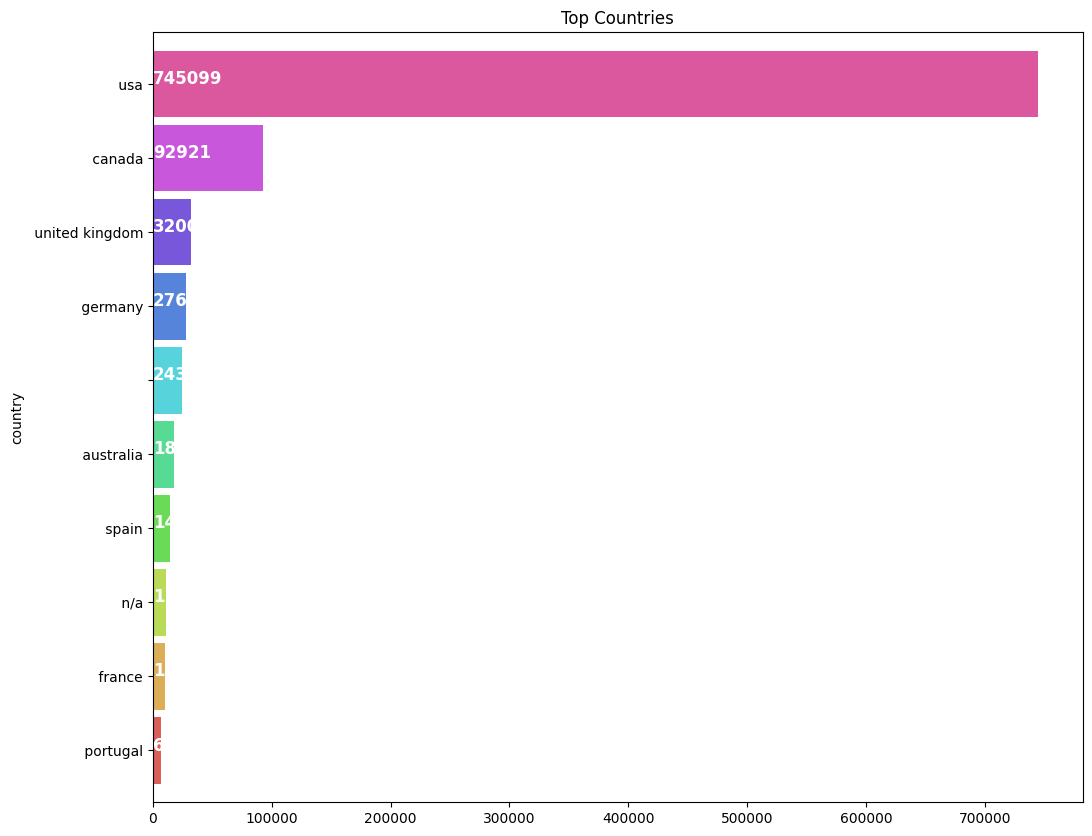

In [561]:
#show the distrubtion of users in each country for the top 10 countries
plt.subplots(figsize=(12,10))
list1 = []
for i in books['country']:
    list1.extend(i)
ax = pd.Series(books['country']).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(books['country']).value_counts()[:10].sort_values(ascending=True).values):
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Countries')
plt.show()


We can see that the majority of hte users are from the us, so what would happen if I asked the system to recommend books based off users from the us, uk and germany. My choices for missing Canada is to get a perspective of an English speaking country that might have a different literary scene than the US, considering their proximity and Germany as the top non-english speaking country. 

In [587]:
#make a new dataset with the countries usa, uk and germany
books2 = books[books['country'].str.contains('usa|uk|germany')]
books2.shape

(772788, 20)

In [588]:
#remove the number 0 from the ratings
books2 = books2[books2['rating'] != 0]
books2.shape

(273951, 20)

In [589]:
books2 = books2.sample(n=10000, random_state=1)
books2.shape

(10000, 20)

In [590]:
books2[:1]

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country,new_id
221552,221552,36304,"union, new jersey, usa",56.0,0156907399,3,To the Lighthouse,Virginia Woolf,1989.0,Harvest Books,http://images.amazon.com/images/P/0156907399.0...,http://images.amazon.com/images/P/0156907399.0...,http://images.amazon.com/images/P/0156907399.0...,"They contend with World War I, family deaths, ...",en,['Married people'],union,new jersey,usa,221552


In [591]:

#make a vocab of the categories
genreList = []
for index, row in books2.iterrows():
    genres = row["country"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)

def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

books2['country_bin'] = books2['country'].apply(lambda x: binary(x))
books2['country_bin'].head()

from scipy import spatial

def Similarity(book_Id1, book_Id2):
    a = books2.iloc[book_Id1]
    b = books2.iloc[book_Id2]
    
    categoryA = a['country_bin']
    categoryB = b['country_bin']
    
    categoriyDistance = spatial.distance.cosine(categoryA, categoryB)
    return categoriyDistance

new_id = list(range(0,books2.shape[0]))
books2['new_id']=new_id
books2=books2[['book_title','country','rating','country_bin','new_id']]
books2.head()


,book_title,country,rating,country_bin,new_id
221552,To the Lighthouse,usa,3,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0
272810,Seven Up (A Stephanie Plum Novel),usa,8,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1
551881,Handy History Answer Book,usa,8,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",2
826903,Murder in the White House,usa,8,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",3
794049,Love and Dreams,usa,9,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",4


In [592]:

import operator

#make a prediction function that takes in a book title and returns the top 10 books that are more similar to it based on the country and the rating
def predict_score(name):
    #name = input('Enter a movie title: ')
    new_book = books2[books2['book_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Book: ',new_book.book_title.values[0])
    def getNeighbors(baseBook, K):
        distances = []
    
        for index, book in books2.iterrows():
            if book['new_id'] != baseBook['new_id'].values[0]:
                dist = Similarity(baseBook['new_id'].values[0], book['new_id'])
                distances.append((book['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_book, K)
    
    print('\nRecommended Books: \n')
    for neighbor in neighbors:
        avgRating = avgRating+books2.iloc[neighbor[0]][2]  
        print( books2.iloc[neighbor[0]][0]+" | Country: "+str(books2.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(books2.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K


In [593]:
predict_score('The Bourne Identity')

Selected Book:  The Bourne Identity

Recommended Books: 

To the Lighthouse | Country: usa | Rating: 3
Seven Up (A Stephanie Plum Novel) | Country: usa | Rating: 8
Handy History Answer Book | Country: usa | Rating: 8
Murder in the White House | Country: usa | Rating: 8
Love and Dreams | Country: usa | Rating: 9
Sullivan's Island: A Lowcountry Tale | Country: usa | Rating: 8
Mountains Beyond Mountains: Healing the World: The Quest of Dr. Paul Farmer | Country: usa | Rating: 10
String Games (Golden Books) | Country: usa | Rating: 10
Richard Scarry's Trains (Golden Little Look-Look Book) | Country: usa | Rating: 10
Tripping over Skyscrapers (Unmistakably Cooper Ellis No. 1) | Country: usa | Rating: 10




In [595]:
#show German books
books2[books2['country'].str.contains('germany')][:3]

,book_title,country,rating,country_bin,new_id
372965,Friedhof der Kuscheltiere. Roman.,germany,8,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]",37
287518,Acqua Alta,germany,10,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]",55
227753,About a Boy,germany,9,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]",59


In [597]:
predict_score('Acqua Alta')

Selected Book:  Acqua Alta

Recommended Books: 

Friedhof der Kuscheltiere. Roman. | Country: germany | Rating: 8
About a Boy | Country: germany | Rating: 9
The Liar | Country: germany | Rating: 8
Sonar UN Crimen (Leer En Espanol, Level 1) | Country: germany | Rating: 7
buongiorno!, Tl.1, Lehrbuch, Italienisch fÃ?Â¼r AnfÃ?Â¤nger | Country: germany | Rating: 8
Tending Roses | Country: germany | Rating: 8
Im Zeichen des LÃ?Â¶wen. | Country: germany | Rating: 8
Knowing How to Know : A Practical Philosophy in the Sufi Tradition | Country: germany | Rating: 10
Die Puppenspieler | Country: germany | Rating: 8
House of Sand and Fog | Country: germany | Rating: 8




In [602]:
#for the books recommended above, show the categories
books[books['book_title'].str.contains('Acqua Alta')][:3] #this is a book that is in English and is a 'Detective and Mystery' book
books[books['book_title'].str.contains('About a Boy')][:3] #ahh, I've just realised that just because a has been read from someone in Germany doesn't mean that it's German or that it has a prodonimantly German audience



,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country,new_id
70519,70519,660,"ny, new york, usa",34.7439,1573229571,8,About a Boy (Movie Tie-In),Nick Hornby,2002.0,Riverhead Books,http://images.amazon.com/images/P/1573229571.0...,http://images.amazon.com/images/P/1573229571.0...,http://images.amazon.com/images/P/1573229571.0...,9,9,9,ny,new york,usa,70519
70520,70520,6251,"wahiawa, hawaii, usa",32.0000,1573229571,0,About a Boy (Movie Tie-In),Nick Hornby,2002.0,Riverhead Books,http://images.amazon.com/images/P/1573229571.0...,http://images.amazon.com/images/P/1573229571.0...,http://images.amazon.com/images/P/1573229571.0...,9,9,9,wahiawa,hawaii,usa,70520
70521,70521,11676,"n/a, n/a, n/a",34.7439,1573229571,7,About a Boy (Movie Tie-In),Nick Hornby,2002.0,Riverhead Books,http://images.amazon.com/images/P/1573229571.0...,http://images.amazon.com/images/P/1573229571.0...,http://images.amazon.com/images/P/1573229571.0...,9,9,9,NaN,NaN,n/a,70521


Whilst this would give better predictions about the perceived quality of the work it doesn't give any more specifics on the similarity of the books and whether the system would make good predictions.

To do this better I want to understand the relationship between the ratings, the number of ratings and the isbn code to be able to recommend more intelligently. 

I'll do this by creating an embedding layer to understand the relationships between the ratings and the isbn code, using the notebook from Week 6.1.

# Embedding's

In [606]:
#load in the dataset
books = pd.read_csv('Books Data with Category Language and Summary/Preprocessed_data.csv')
books.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


In [608]:
#make country into a string
books['country'] = books['country'].astype(str)

In [449]:
books

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,...,img_l,Summary,Language,Category,city,state,country,rating1,isbn_bin,rating_bin
55849,55849,272202,"cleveland, mississippi, usa",34.7439,0060392452,9,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002.0,Regan Books,...,http://images.amazon.com/images/P/0060392452.0...,So if you&#39;re feeling the same way and you&...,en,['Political Science'],cleveland,mississippi,usa,9,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
262176,262176,74655,"wien, wien, austria",32.0000,3453212045,5,Sushi fÃ?Â¼r AnfÃ?Â¤nger.,Marian Keyes,2002.0,Heyne,...,http://images.amazon.com/images/P/3453212045.0...,9,9,9,wien,wien,austria,5,"[1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
292564,292564,124946,"elizabeth, arkansas, usa",56.0000,0767915054,4,A Girl Named Zippy: Growing Up Small in Moorel...,HAVEN KIMMEL,2002.0,Broadway Books,...,http://images.amazon.com/images/P/0767915054.0...,The author offers a chronicle of growing up in...,en,['Biography & Autobiography'],elizabeth,arkansas,usa,4,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
190720,190720,102275,"saint clair, michigan, usa",52.0000,0142000345,10,A Common Life: The Wedding Story (Beloved Mitf...,Jan Karon,2002.0,Viking Books,...,http://images.amazon.com/images/P/0142000345.0...,The creator of the Mitford stories goes back t...,en,['Fiction'],saint clair,michigan,usa,10,"[1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]"
10301,10301,130950,"jersey city, new jersey, usa",32.0000,0671027360,9,Angels & Demons,Dan Brown,2001.0,Pocket Star,...,http://images.amazon.com/images/P/0671027360.0...,9,9,9,jersey city,new jersey,usa,9,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530362,530362,72147,"merrimack, new hampshire,",34.7439,0425141977,8,A Share in Death,Deborah Crombie,1994.0,Berkley Publishing Group,...,http://images.amazon.com/images/P/0425141977.0...,9,9,9,merrimack,"new hampshire,",NaN,8,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
920652,920652,185233,"winnemucca, nevada, usa",31.0000,0553143573,5,Who Killed Harlowe Thrombey,Edward Packard,1981.0,Bantam Books (Mm),...,http://images.amazon.com/images/P/0553143573.0...,9,9,9,winnemucca,nevada,usa,5,"[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
938233,938233,160401,"akron, ohio, usa",30.0000,0373030886,5,"Perfect Marriage (Harlequin Romance, No 3088)",Lee Stafford,1990.0,Harlequin,...,http://images.amazon.com/images/P/0373030886.0...,9,9,9,akron,ohio,usa,5,"[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
748394,748394,64726,"eaubonne, ile de france, france",27.0000,2070320006,7,Oeuvres complÃ?Â¨tes,LautrÃ?Â©amont,1973.0,Gallimard,...,http://images.amazon.com/images/P/2070320006.0...,Les Chants de Maldoror sont une épopée en pros...,fr,['Poetry'],eaubonne,ile de france,france,7,"[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [450]:
#making vocabs for the categories
user_ids = books["user_id"].unique().tolist()
isbn_ids = books["isbn"].unique().tolist()

print(len(user_ids))
print(len(isbn_ids))
isbn_ids[:5]

6268
8486


['0060392452', '3453212045', '0767915054', '0142000345', '0671027360']

In [451]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
isbn_id_to_index = {x: i for i, x in enumerate(isbn_ids)}

In [452]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
books["user_index"] = [user_id_to_index[i] for i in books["user_id"]]
books["isbn_index"] = [isbn_id_to_index[i] for i in books["isbn"]]

In [453]:
#reduce the columns in books to include 'isbn', user_ids, rating, user_index and isbn_index
books = books[['isbn','user_id','rating','book_title', 'Category', 'user_index','isbn_index']]
books

,isbn,user_id,rating,book_title,Category,user_index,isbn_index
55849,0060392452,272202,9,Stupid White Men ...and Other Sorry Excuses fo...,['Political Science'],0,0
262176,3453212045,74655,5,Sushi fÃ?Â¼r AnfÃ?Â¤nger.,9,1,1
292564,0767915054,124946,4,A Girl Named Zippy: Growing Up Small in Moorel...,['Biography & Autobiography'],2,2
190720,0142000345,102275,10,A Common Life: The Wedding Story (Beloved Mitf...,['Fiction'],3,3
10301,0671027360,130950,9,Angels & Demons,9,4,4
...,...,...,...,...,...,...,...
530362,0425141977,72147,8,A Share in Death,9,6266,5988
920652,0553143573,185233,5,Who Killed Harlowe Thrombey,9,651,8483
938233,0373030886,160401,5,"Perfect Marriage (Harlequin Romance, No 3088)",9,773,8484
748394,2070320006,64726,7,Oeuvres complÃ?Â¨tes,['Poetry'],6267,8485


In [454]:
books["rating"].describe()

count    10000.000000
mean         7.643000
std          1.835725
min          1.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         10.000000
Name: rating, dtype: float64

In [455]:
import sklearn

In [456]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
books["rating"] = MinMaxScaler().fit_transform(books["rating"].values.reshape(-1, 1)) #normalise the ratings

In [457]:
books["rating"].describe()

count    10000.000000
mean         0.738111
std          0.203969
min          0.000000
25%          0.666667
50%          0.777778
75%          0.888889
max          1.000000
Name: rating, dtype: float64

In [458]:
print(len(books['user_index']))
print(len(books['isbn_index']))

10000
10000


In [459]:
from sklearn.model_selection import train_test_split
#Inputs
x = books[["user_index", "isbn_index"]]
#Outputs
y = books["rating"]
#Get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

In [460]:
print(len(x_train))
len(y_train)

9000


9000

In [461]:
#make a class using pytorch to create the model
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class BookDataset(Dataset):
    def __init__(self, users, items, ratings):
        self.users = users
        self.items = items
        self.ratings = ratings
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [462]:
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_isbn, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.isbn_embedding = torch.nn.Embedding(num_isbn, embedding_size)
        self.isbn_bias = torch.nn.Embedding(num_isbn, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        isbn_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        isbn_vector = self.isbn_embedding(isbn_indexes)
        isbn_bias = self.isbn_bias(isbn_indexes).flatten()
        #Dot product
        dot = (user_vector * isbn_vector).sum(1)
        with_bias = dot + user_bias + isbn_bias
        #Activation function
        output = self.sig(with_bias)
        return output

In [463]:
#Pick Embedding size
EMBEDDING_SIZE = 20
#Make new object (calls __init__())
num_users = len(user_ids)
num_isbn = len(isbn_ids)
model = RecommenderNet(num_users, num_isbn, EMBEDDING_SIZE)

In [464]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [465]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values,y_val.values), batch_size=64, shuffle=True)

In [466]:
epochs = 10
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [467]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.2654673755168915 Validation Loss 0.2535982131958008
Loss 0.1619592159986496 Validation Loss 0.25044411420822144
Loss 0.09311235696077347 Validation Loss 0.2475687563419342
Loss 0.06606900691986084 Validation Loss 0.24591580033302307
Loss 0.0553826205432415 Validation Loss 0.2450244426727295
Loss 0.0525301955640316 Validation Loss 0.2447517067193985
Loss 0.04989949241280556 Validation Loss 0.24208030104637146
Loss 0.048679549247026443 Validation Loss 0.24186065793037415
Loss 0.04891328141093254 Validation Loss 0.24284487962722778
Loss 0.04769571125507355 Validation Loss 0.2429153025150299


In [468]:
torch.save(model.state_dict(), 'model_weights.pth')

In [469]:
model = RecommenderNet(num_users, num_isbn, EMBEDDING_SIZE)
model

RecommenderNet(
  (user_embedding): Embedding(6268, 20)
  (user_bias): Embedding(6268, 1)
  (isbn_embedding): Embedding(8486, 20)
  (isbn_bias): Embedding(8486, 1)
  (sig): Sigmoid()
)

In [470]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [471]:
model.eval()

RecommenderNet(
  (user_embedding): Embedding(6268, 20)
  (user_bias): Embedding(6268, 1)
  (isbn_embedding): Embedding(8486, 20)
  (isbn_bias): Embedding(8486, 1)
  (sig): Sigmoid()
)

In [472]:
#use function to get the embeddings for the isbn
isbn_embeddings = model.isbn_embedding.weight.data
isbn_embeddings

tensor([[-0.0647,  0.2403,  0.2577,  ...,  0.6595, -2.7565, -0.0126],
        [ 0.0570, -0.5305,  0.8719,  ...,  0.4931, -2.2596,  0.4485],
        [-0.0892, -1.2474,  1.8331,  ...,  0.4545,  0.7896,  0.1549],
        ...,
        [ 0.6000,  0.7385,  0.4317,  ..., -1.6399, -1.1472, -2.2847],
        [-1.5757,  1.7181,  0.9280,  ..., -1.1441,  0.6905,  0.5188],
        [ 0.8824, -2.1758, -1.3079,  ..., -0.0389, -1.0737,  0.8607]])

In [473]:
#make a consine similarity matrix for the isbn embeddings
from sklearn.metrics.pairwise import cosine_similarity
isbn_similarities = cosine_similarity(isbn_embeddings)
isbn_similarities[:5]

array([[ 0.99999994,  0.44087785, -0.32702738, ...,  0.2518152 ,
        -0.25571787, -0.02024512],
       [ 0.44087785,  1.        , -0.0353299 , ..., -0.17404842,
        -0.2566111 ,  0.36283037],
       [-0.32702738, -0.0353299 ,  1.        , ..., -0.3938012 ,
         0.24200273,  0.2831098 ],
       [-0.42081138,  0.17849308,  0.08328544, ..., -0.3874851 ,
        -0.14167485,  0.4382992 ],
       [-0.20899013, -0.08917551,  0.0359809 , ..., -0.24225323,
        -0.31222427,  0.58532596]], dtype=float32)

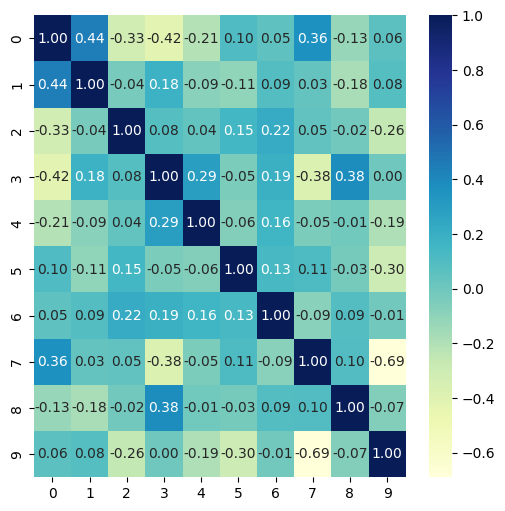

In [474]:
#visualise the isbn similarities as a heatmap
plt.figure(figsize=(6,6))
sns.heatmap(isbn_similarities[:10,:10], annot=True, fmt='.2f', cmap="YlGnBu");


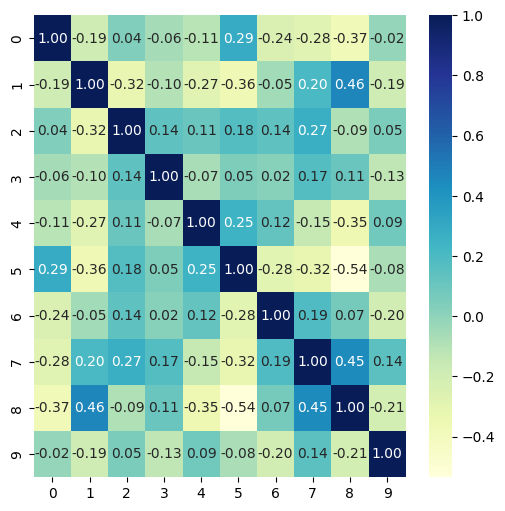

In [475]:
#use the embedding's to make predictions for the user
user_embeddings = model.user_embedding.weight.data
user_embeddings

#make a consine similarity matrix for the user embeddings
from sklearn.metrics.pairwise import cosine_similarity
user_similarities = cosine_similarity(user_embeddings)
user_similarities[:5]

#visualise the user similarities as a heatmap
plt.figure(figsize=(6,6))
sns.heatmap(user_similarities[:10,:10], annot=True, fmt='.2f', cmap="YlGnBu");


In [476]:
#make a function to predict similar books for a given book
def predict_similar_books(isbn_id, isbn_to_id, id_to_isbn, isbn_similarities, n_recommendations=10):
    #Get the index of the movie
    isbn_idx = isbn_to_id[isbn_id]
    #Get the pairwise similarity scores 
    sim_scores = [(idx, score) for (idx, score) in enumerate(isbn_similarities[isbn_idx]) if idx != isbn_idx]
    #Sort the movies 
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Get the scores of the 10 most similar movies 
    sim_scores = sim_scores[:n_recommendations]
    #Get the movie indices
    isbn_indices = [idx for (idx, _) in sim_scores]
    #Return the top 10 most similar movies
    return id_to_isbn.iloc[isbn_indices]    


In [477]:
#use recommender system to predict similar books for a given book
isbn_id = '0316666343'
n_recommendations = 10
isbn_to_id = pd.Series(isbn_id_to_index)
id_to_isbn = pd.Series(isbn_ids).sort_values(ascending=True)
isbn_to_id[isbn_id]

predict_similar_books(isbn_id, isbn_to_id, id_to_isbn, isbn_similarities, n_recommendations)

2102    1551667517
1029    0451191137
6827    8408021915
233     0312983301
5510    0767915062
1708    0140236201
1063    0786884649
3144    3257230982
2405    0312278586
7278    0316693316
dtype: object

Whilst working with ISBN codes makes it easier, it means that I have to put a bit more work into hte post processing to get the actual books.

In [478]:
prediction = predict_similar_books(isbn_id, isbn_to_id, id_to_isbn, isbn_similarities, n_recommendations)

#for isbn ids in prediction get the book title
books[books['isbn_index'].isin(prediction.index)]


,isbn,user_id,rating,book_title,Category,user_index,isbn_index
296233,0312983301,221008,0.666667,Full Blast (Janet Evanovich's Full Series),['Fiction'],222,233
254194,0451191137,22464,0.777778,Anthem,9,923,1029
304550,0786884649,219353,0.444444,Confessions of a Cineplex Heckler : Celluloid ...,['Humor'],949,1063
190460,0140236201,166478,0.777778,Paradise of the Blind,['Fiction'],1489,1708
467594,1551667517,185275,0.444444,Forbidden Fruit (Mira),9,1795,2102
49869,0312278586,244517,0.666667,The Nanny Diaries: A Novel,['Fiction'],2030,2405
49730,0312278586,162762,1.000000,The Nanny Diaries: A Novel,['Fiction'],2239,2405
490385,3257230982,12835,0.555556,Der Spion und der Dichter.,9,1677,3144
49668,0312278586,133846,0.777778,The Nanny Diaries: A Novel,['Fiction'],2628,2405
296243,0312983301,241980,0.888889,Full Blast (Janet Evanovich's Full Series),['Fiction'],233,233


So users who enjoyed '0316666343', which is The Lovely Bones: A Novel would also enjoy the books above. THere do seem to be some issues with the system recommending the same books several times (The Green Mile, and The Handmaid's Tale: A Novel appear twice on the list above).

Because the Category 'column' is fairly unnuanced it means there there are generally fairly similar for the most part. When I removed 9 from the dataset it broke my model so for the moment I am just leaving it as is. 

Lets see if I can find information that can recommend books for a particular user rather than recommending books from other books.

In [317]:
#make a finction that recommends books for a given user using their user index
def recommend_books(user_index, isbn_to_id, id_to_isbn, isbn_similarities, n_recommendations=10):
    #Get the pairwise similarity scores 
    sim_scores = [(idx, score) for (idx, score) in enumerate(user_similarities[user_index])]
    #Sort the movies 
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Get the scores of the 10 most similar movies 
    sim_scores = sim_scores[:n_recommendations]
    #Get the movie indices
    isbn_indices = [idx for (idx, _) in sim_scores]
    #Return the top 10 most similar movies
    return id_to_isbn.iloc[isbn_indices]

#use recommender system to predict similar books for a given user
user_index = 20
n_recommendations = 10
isbn_to_id = pd.Series(isbn_id_to_index)
id_to_isbn = pd.Series(isbn_ids).sort_values(ascending=True)
isbn_to_id[isbn_id]

recommend_books(user_index, isbn_to_id, id_to_isbn, isbn_similarities, n_recommendations)

prediction = recommend_books(user_index, isbn_to_id, id_to_isbn, isbn_similarities, n_recommendations)

In [321]:
prediction

6802    0007127863
860     0789480344
98      0451459083
3098    0064407667
7307    0744523311
5272    0553582658
6917    0345289676
7549    055308576X
978     0140620222
2727    0449221431
dtype: object

In [318]:
#for the isbn ids in the prediction get the book title
books[books['isbn_index'].isin(prediction.index)]


,isbn,user_id,rating,book_title,Category,user_index,isbn_index
854747,0451459083,98391,0.888889,Conquistador,9,11,98
677826,0789480344,226553,0.777778,KISS Guide to Yoga,['Health & Fitness'],768,860
315364,0140620222,263107,0.888889,Pride and Prejudice (Penguin Popular Classics),9,879,978
300148,0449221431,266164,0.555556,The Novel,['Fiction'],2283,2727
69061,0064407667,68249,0.777778,The Bad Beginning (A Series of Unfortunate Eve...,['Juvenile Fiction'],2568,3098
92981,0553582658,204844,0.555556,Summer Light,['Fiction'],4125,5272
69010,0064407667,11676,0.222222,The Bad Beginning (A Series of Unfortunate Eve...,['Juvenile Fiction'],47,3098
866963,0007127863,244309,0.777778,Red Shift,9,5195,6802
992082,0345289676,216329,0.777778,Fantasy Worlds of Peter S. Beagle,9,5281,6917
69095,0064407667,110934,0.777778,The Bad Beginning (A Series of Unfortunate Eve...,['Juvenile Fiction'],831,3098


Again there is the issue of recommending the same book twice (on several occasions) but the system does work at recommending books based on an original user.

I want to see if the genres of the books recommended are similar (this will be limited as the books are broken into vague categories rather than specific genres)


In [323]:
books


,isbn,user_id,rating,book_title,Category,user_index,isbn_index
55849,0060392452,272202,0.888889,Stupid White Men ...and Other Sorry Excuses fo...,['Political Science'],0,0
262176,3453212045,74655,0.444444,Sushi fÃ?Â¼r AnfÃ?Â¤nger.,9,1,1
292564,0767915054,124946,0.333333,A Girl Named Zippy: Growing Up Small in Moorel...,['Biography & Autobiography'],2,2
190720,0142000345,102275,1.000000,A Common Life: The Wedding Story (Beloved Mitf...,['Fiction'],3,3
10301,0671027360,130950,0.888889,Angels & Demons,9,4,4
...,...,...,...,...,...,...,...
530362,0425141977,72147,0.777778,A Share in Death,9,6266,5988
920652,0553143573,185233,0.444444,Who Killed Harlowe Thrombey,9,651,8483
938233,0373030886,160401,0.444444,"Perfect Marriage (Harlequin Romance, No 3088)",9,773,8484
748394,2070320006,64726,0.666667,Oeuvres complÃ?Â¨tes,['Poetry'],6267,8485


In [326]:
#from books get the book title for the isbn ids in the prediction
books[books['isbn_index'].isin(prediction.index)]['Category']


854747                       9
677826    ['Health & Fitness']
315364                       9
300148             ['Fiction']
69061     ['Juvenile Fiction']
92981              ['Fiction']
69010     ['Juvenile Fiction']
866963                       9
992082                       9
69095     ['Juvenile Fiction']
822476            ['Brothers']
404239             ['Fiction']
69128     ['Juvenile Fiction']
Name: Category, dtype: object

In [489]:
#for hte isbn in predictions get the embedding
embeddings = isbn_embeddings[prediction.index]
embeddings[:1]


tensor([[ 0.1463, -0.1875, -0.4643,  1.6449,  0.0550,  1.9093, -0.0775,  1.4605,
         -1.2350, -0.2540, -0.4377,  0.0554,  1.5322,  0.1386,  1.3024,  1.7414,
          0.2704, -0.0051,  0.8793, -0.8090]])

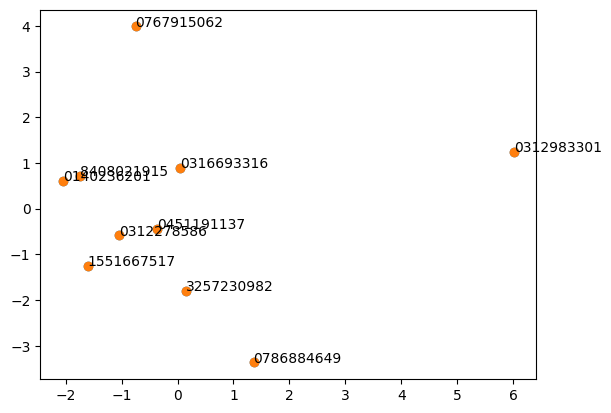

In [492]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embeddings.detach().numpy())
pca_embeddings = pca.transform(embeddings.detach().numpy())

pca_embeddings

plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1])

#labelling the embeddings
for i, txt in enumerate(prediction[:]):
    plt.annotate(txt, (pca_embeddings[i,0], pca_embeddings[i,1]))

#plotting
plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1])

As a recap of what I did in this notebook
1. Adjusted a pre-existing recommender system that used content based filtering to get results
    1. Reducing the dataset while retaining the distrubtion/most valuable variables
    2. Visualising the categories 
2. Changed the content the system was using to get different results (rating/locaiton)
3. 